### Import required packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar
import pandas_datareader.data as web
import warnings
warnings.filterwarnings("ignore")
from functions import delta_hedging, calendar_to_business_days, create_straddles, process_straddles, dp_hedging_collect_training_data, train_random_forest_model, apply_hedging_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

### Initialize important dates

In [2]:
start_date = '2007-01-01'
end_date = '2023-09-30'

training_start_date = '2007-01-01'
training_end_date = '2015-12-31'
test_start_date = '2016-01-01'
test_end_date = '2023-08-31'

### Fetch and Process S&P prices data

In [3]:
sp = yf.download('^SPX')

sp.index = pd.to_datetime(sp.index)

# Filter the DataFrame
filtered_sp = sp.loc[start_date:end_date]

# Remove the ticker level from the multi index
filtered_sp.columns = filtered_sp.columns.droplevel(1)
filtered_sp = pd.DataFrame(filtered_sp['Close'], index=filtered_sp.index)
filtered_sp.index = pd.to_datetime(filtered_sp.index).tz_localize(None)

[*********************100%***********************]  1 of 1 completed


### Fetch and Process Fama French Risk free rate data

In [4]:
# Fetch the Fama-French 3-factor data
ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)

# Convert period index to datetime
rf_data = ff_data[0]  # Extract the first dataframe (RF)
rf_data.index = rf_data.index.to_timestamp()  

# Select the RF column (risk-free rate)
risk_free_rate = pd.DataFrame(rf_data['RF'])

# Resample to daily frequency, forward-fill missing values (public holidays), and annualize the risk free rate
risk_free_rate = risk_free_rate.resample('D').ffill()
risk_free_rate = risk_free_rate * 12 / 100

### Reindex data to forward fill prices and risk free for public holidays

In [5]:
market_df = filtered_sp.merge(risk_free_rate, left_index=True, right_index=True)

# Create a new business day index
new_index = pd.bdate_range(start=start_date, end=end_date)

# Create a new DataFrame with the business day index
real_market_df = pd.DataFrame(index=new_index)

# Merge the existing market_df with the new DataFrame
real_market_df = real_market_df.merge(market_df, left_index=True, right_index=True, how='left')

# Forward fill the missing values
real_market_df.ffill(inplace=True)

# Rename the index to 'Date' if necessary
real_market_df.index.name = 'Date'

# Display the updated DataFrame
real_market_df

,Close,RF
Date,,
2007-01-01,NaN,NaN
2007-01-02,NaN,NaN
2007-01-03,1416.599976,0.0528
2007-01-04,1418.339966,0.0528
2007-01-05,1409.709961,0.0528
...,...,...
2023-09-25,4515.770020,0.0516
2023-09-26,4515.770020,0.0516
2023-09-27,4515.770020,0.0516


### Read Option data

In [6]:
# Read data from CSV
data = pd.read_csv('filtered_data_cleaned.csv')
data.set_index('Date', inplace=True)

In [7]:
data

,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,vega,theta,optionid,contract_size,D to Expiration,Close,Moneyness
Date,,,,,,,,,,,,,,,,
2000-01-03,2000-01-22,P,1465.0,30.000,32.000,68,0.218037,-0.521459,0.005654,128.7359,-237.8190,10526329,100,19,1455.219971,1.006721
2000-01-03,2000-01-22,P,1440.0,19.875,21.125,691,0.227943,-0.385638,0.005192,123.5883,-251.1784,10563021,100,19,1455.219971,0.989541
2000-01-03,2000-01-22,C,1460.0,23.375,25.375,386,0.191068,0.505087,0.006461,128.9120,-291.8110,10949021,100,19,1455.219971,1.003285
2000-01-03,2000-01-22,C,1450.0,29.125,32.000,1312,0.198929,0.567313,0.006117,127.0829,-303.3932,11070856,100,19,1455.219971,0.996413
2000-01-03,2000-01-22,C,1465.0,20.625,22.625,0,0.187986,0.472246,0.006551,128.6103,-284.5414,11274505,100,19,1455.219971,1.006721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,2023-09-29,P,4435.0,28.800,29.100,21,0.128259,-0.281094,0.002070,428.5164,-279.8151,154635934,100,29,4507.660156,0.983881
2023-08-31,2023-10-02,C,4515.0,65.400,65.900,0,0.111276,0.540238,0.002672,529.7147,-455.4730,156631215,100,32,4507.660156,1.001628
2023-08-31,2023-10-02,P,4515.0,53.500,53.900,12,0.112415,-0.459972,0.002645,529.7515,-232.4544,156631264,100,32,4507.660156,1.001628


### Define training and testing data

In [8]:
data_train = data[training_start_date:training_end_date]
option_df_train = data_train
data_train.index = pd.to_datetime(data_train.index)

data_test = data[test_start_date:test_end_date]
option_df_test = data_test

### Compute MidPrice and convert calendar days to business days

In [9]:
# Get midprice for all data
data_train['Midprice'] = (data_train['best_bid'] + data_train['best_offer']) / 2
data_test['Midprice'] = (data_test['best_bid'] + data_test['best_offer']) / 2

# convert calendar to business days
option_df_train['Business_Days_to_Expiration'] = option_df_train.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)
option_df_test['Business_Days_to_Expiration'] = option_df_test.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)

### Keep only options with 1 month or more to maturity

In [10]:
data_1m_train = data_train[data_train['Business_Days_to_Expiration'] >= 22]
data_1m_train.index = pd.to_datetime(data_1m_train.index)

data_1m_test = data_test[data_test['Business_Days_to_Expiration'] >= 22]
data_1m_test.index = pd.to_datetime(data_1m_test.index)

### Create Straddles for each dates

In [11]:
# Group the data by date, strike price, and expiration date
groups_train = data_1m_train.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])
groups_test = data_1m_test.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])

straddles_df_train = create_straddles(groups_train)
straddles_df_test = create_straddles(groups_test)

### If the straddle starts later than 10th of the month, remove it to comply with the requirement that we choose a straddle at the "beginning" of the month

In [12]:
for dates in straddles_df_train.index:
    if dates.day > 10:
        straddles_df_train.drop(dates, inplace=True, errors='ignore')

for dates in straddles_df_test.index:
    if dates.day > 10:
        straddles_df_test.drop(dates, inplace=True, errors='ignore')

### For each month, choose only one straddle, the one with a moneyness closest to 1

In [13]:
first_straddles_monthly_train = process_straddles(straddles_df_train)
first_straddles_monthly_test = process_straddles(straddles_df_test)

In [14]:
# No transaction cost, training P&L
profit_no_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0)
profit_no_cost_train.set_index('Date', inplace=True)
profit_no_cost_train['Cumulative P&L'] = profit_no_cost_train['P&L'].cumsum()
profit_no_cost_train

,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2007-01-10,37.15,37.345416,30.540039,46.313152,6.805377,6.805377
2007-02-07,34.45,34.674563,63.050049,805.168173,-28.375485,-21.570109
2007-04-10,40.70,40.968709,72.750000,1010.050430,-31.781291,-53.351399
2007-05-10,47.35,47.638425,42.910034,22.357683,4.728391,-48.623008
2007-07-10,62.15,62.527273,64.060059,2.349433,-1.532786,-50.155794
...,...,...,...,...,...,...
2015-08-05,57.65,57.650000,147.709961,8110.796564,-90.059961,883.215392
2015-09-02,99.65,99.650000,26.180054,5397.833008,73.469946,956.685338
2015-10-07,73.75,73.750000,104.929932,972.188137,-31.179932,925.505406


In [15]:
# Transaction cost, testing P&L
profit_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0.005)
profit_cost_train.set_index('Date', inplace=True)
profit_cost_train['Cumulative P&L'] = profit_cost_train['P&L'].cumsum()
profit_cost_train

,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2007-01-10,37.15,37.098176,30.540039,43.009161,6.558137,6.558137
2007-02-07,34.45,33.578254,63.050049,868.586676,-29.471795,-22.913658
2007-04-10,40.70,40.280449,72.750000,1054.271756,-32.469551,-55.383209
2007-05-10,47.35,46.597300,42.910034,13.595930,3.687266,-51.695943
2007-07-10,62.15,61.863732,64.060059,4.823852,-2.196327,-53.892270
...,...,...,...,...,...,...
2015-08-05,57.65,57.212971,147.709961,8189.705227,-90.496990,863.168294
2015-09-02,99.65,99.396025,26.180054,5360.578388,73.215971,936.384265
2015-10-07,73.75,73.691073,104.929932,975.866282,-31.238859,905.145407


In [16]:
# No transaction cost, training P&L
profit_no_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0)
profit_no_cost_test.set_index('Date', inplace=True)
profit_no_cost_test['Cumulative P&L'] = profit_no_cost_test['P&L'].cumsum()
profit_no_cost_test

,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2016-01-06,83.50,83.510379,74.550049,80.287513,8.960330,8.960330
2016-02-04,95.00,95.023291,74.569946,418.339329,20.453345,29.413675
2016-03-10,79.65,79.665468,92.780029,171.991721,-13.114561,16.299114
2016-04-05,72.95,72.959369,19.110107,2899.742994,53.849262,70.148376
2016-05-04,66.45,66.457352,55.260010,125.380478,11.197342,81.345718
...,...,...,...,...,...,...
2023-04-06,173.75,174.563819,25.620117,22184.226330,148.943702,900.742181
2023-05-08,141.80,142.450138,153.930176,131.791259,-11.480037,889.262144
2023-06-08,108.60,109.156772,103.950195,27.108439,5.206577,894.468720


In [17]:
# Transaction cost, testing P&L
profit_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0.005)
profit_cost_test.set_index('Date', inplace=True)
profit_cost_test['Cumulative P&L'] = profit_cost_test['P&L'].cumsum()
profit_cost_test

,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2016-01-06,83.50,83.468310,74.550049,79.535376,8.918261,8.918261
2016-02-04,95.00,94.899783,74.569946,413.302244,20.329836,29.248097
2016-03-10,79.65,79.422018,92.780029,178.436479,-13.358012,15.890085
2016-04-05,72.95,72.583347,19.110107,2859.387353,53.473240,69.363325
2016-05-04,66.45,66.202729,55.260010,119.743105,10.942719,80.306044
...,...,...,...,...,...,...
2023-04-06,173.75,173.010255,25.620117,21723.852629,147.390137,866.072764
2023-05-08,141.80,141.013588,153.930176,166.838252,-12.916588,853.156176
2023-06-08,108.60,106.853616,103.950195,8.429851,2.903421,856.059597


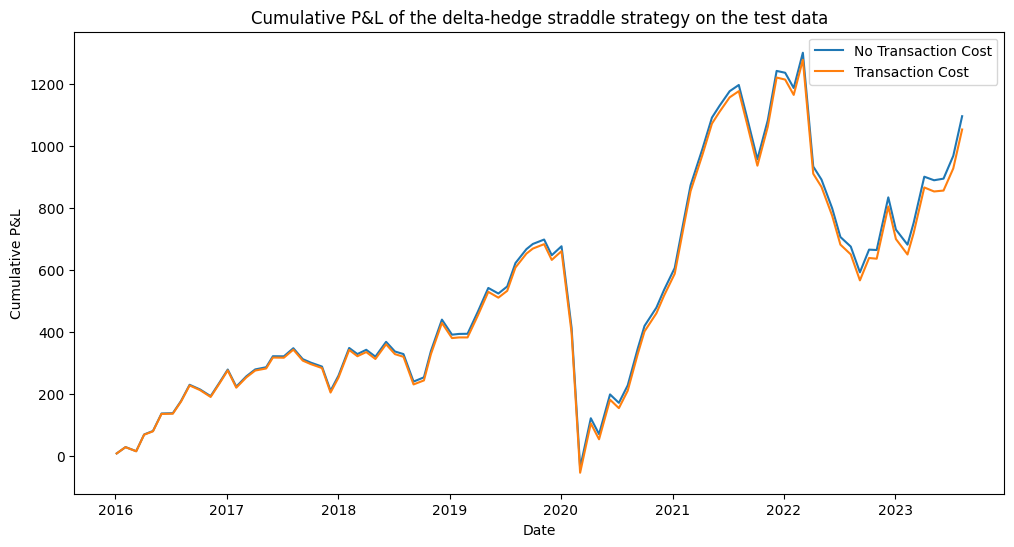

In [18]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_no_cost_test['Cumulative P&L'], label='No Transaction Cost')
plt.plot(profit_cost_test['Cumulative P&L'], label='Transaction Cost')
plt.title('Cumulative P&L of the delta-hedge straddle strategy on the test data')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

In [19]:
results_monthly = dp_hedging_collect_training_data(first_straddles_monthly_train, data_train, real_market_df)
results_monthly.set_index('Date', inplace=True)

In [20]:
rf_monthly = train_random_forest_model(results_monthly)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [21]:
# Apply the hedging model to the test set
results_df_monthly = apply_hedging_model(first_straddles_monthly_test, data_test, real_market_df, rf_monthly, transaction_cost=0.005)

# View the results
results_df_monthly['Cumulative P&L'] = results_df_monthly['P&L'].cumsum()
results_df_monthly.set_index('StartDate', inplace=True)

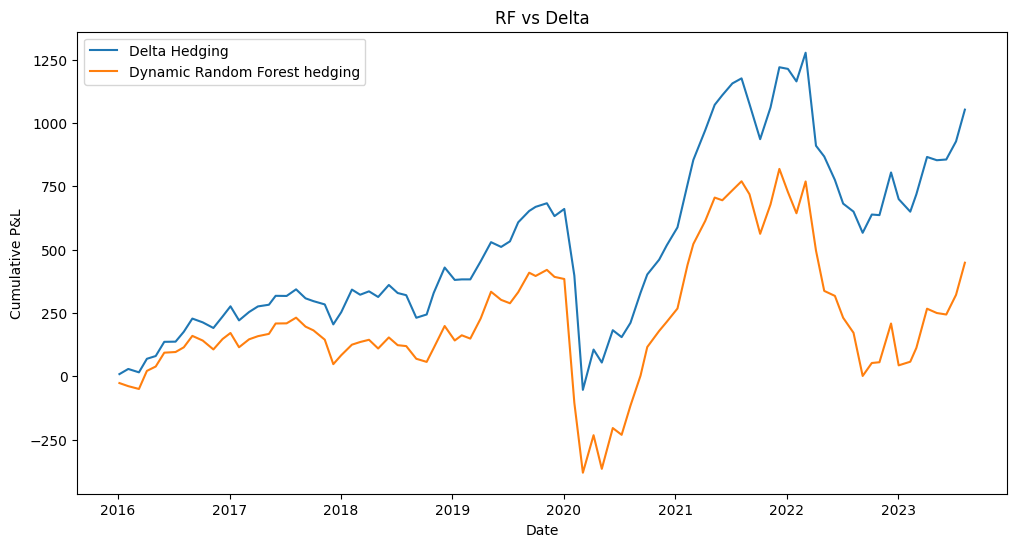

In [22]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_cost_test['Cumulative P&L'], label='Delta Hedging')
plt.plot(results_df_monthly['Cumulative P&L'], label='Dynamic Random Forest hedging')
plt.title('RF vs Delta')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

In [26]:
results_daily = dp_hedging_collect_training_data(straddles_df_train, data_train, real_market_df)
results_daily.set_index('Date', inplace=True)

In [27]:
rf_daily = train_random_forest_model(results_daily)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [28]:
# Apply the hedging model to the test set
results_df_daily = apply_hedging_model(first_straddles_monthly_test, data_test, real_market_df, rf_daily, transaction_cost=0.005)

# View the results
results_df_daily['Cumulative P&L'] = results_df_daily['P&L'].cumsum()
results_df_daily.set_index('StartDate', inplace=True)

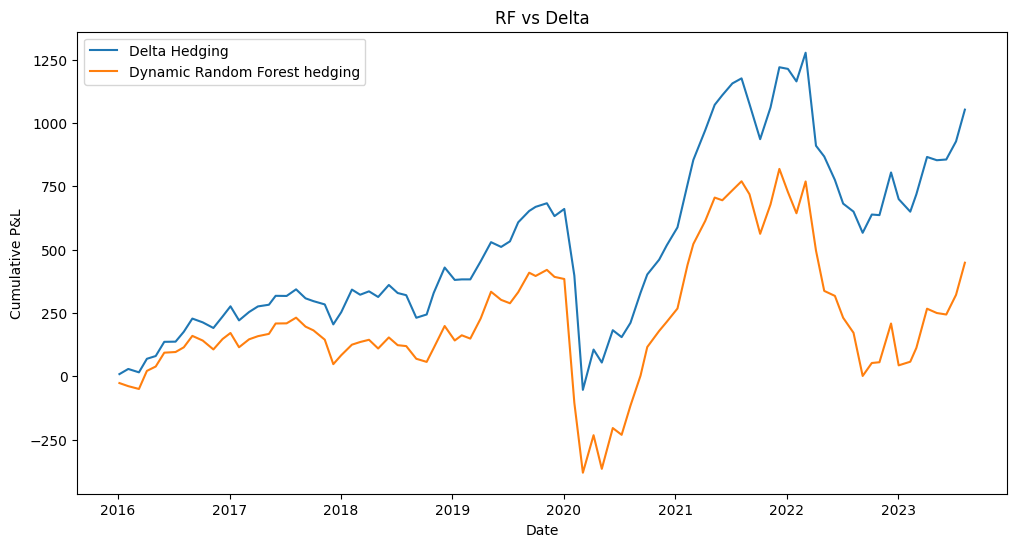

In [30]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_cost_test['Cumulative P&L'], label='Delta Hedging')
plt.plot(results_df_daily['Cumulative P&L'], label='Dynamic Random Forest hedging')
plt.title('RF vs Delta')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()